In [1]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder

# =============================
# 1. Load datasets
# =============================
train_df = pd.read_csv("../data/twitter_training.csv")
val_df = pd.read_csv("../data/twitter_validation.csv")

print("🔹 Original Training shape:", train_df.shape)
print("🔹 Original Validation shape:", val_df.shape)

# =============================
# 2. Remove null values
# =============================
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)

# =============================
# 3. Remove duplicates and Irrelevent
# =============================
train_df.drop_duplicates(inplace=True)
val_df.drop_duplicates(inplace=True)
train_df = train_df[train_df['sentiment'] != 'Irrelevant']
val_df = val_df[val_df['sentiment'] != 'Irrelevant']

# =============================
# 4. Text cleaning function
# =============================
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)   # remove URLs
    text = re.sub(r"@\w+", "", text)             # remove @mentions
    text = re.sub(r"#\w+", "", text)             # remove hashtags
    text = re.sub(r"[^a-z\s]", "", text)         # remove non-letters
    text = re.sub(r"\s+", " ", text).strip()     # remove extra spaces
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
val_df['clean_text'] = val_df['text'].apply(clean_text)



# =============================
# 5. Encode sentiment labels
# =============================
label_encoder = LabelEncoder()
train_df['sentiment_encoded'] = label_encoder.fit_transform(train_df['sentiment'])
val_df['sentiment_encoded'] = label_encoder.transform(val_df['sentiment'])

print("\n✅ Preprocessing complete")
print("Unique sentiments:", label_encoder.classes_)
print(train_df.head())


🔹 Original Training shape: (74682, 4)
🔹 Original Validation shape: (1000, 4)

✅ Preprocessing complete
Unique sentiments: ['Negative' 'Neutral' 'Positive']
     id       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

                                          clean_text  sentiment_encoded  
0  im getting on borderlands and i will murder yo...                  2  
1  i am coming to the borders and i will kill you...                  2  
2  im getting on borderlands and i will kill you all                  2  
3  im 

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# =============================
# 6. TF-IDF Vectorization
# =============================
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  
X_train_tfidf = vectorizer.fit_transform(train_df['clean_text'])
X_val_tfidf = vectorizer.transform(val_df['clean_text'])

y_train = train_df['sentiment_encoded']
y_val = val_df['sentiment_encoded']

print("🔹 TF-IDF train shape:", X_train_tfidf.shape)
print("🔹 TF-IDF val shape:", X_val_tfidf.shape)


🔹 TF-IDF train shape: (59119, 5000)
🔹 TF-IDF val shape: (828, 5000)


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# =============================
# 7. Train models
# =============================
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_tfidf, y_train)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# =============================
# 8. Predictions
# =============================
y_pred_log = log_reg.predict(X_val_tfidf)
y_pred_nb = nb_model.predict(X_val_tfidf)

# =============================
# 9. Evaluation
# =============================
log_acc = accuracy_score(y_val, y_pred_log)
nb_acc = accuracy_score(y_val, y_pred_nb)

print(f"🔹 Logistic Regression Accuracy: {log_acc:.2f}") 
print(f"🔹 Naive Bayes Accuracy: {nb_acc:.2f}")


print("\n🔹 Logistic Regression Classification Report:\n", classification_report(y_val, y_pred_log))
print("\n🔹 Naive Bayes Classification Report:\n", classification_report(y_val, y_pred_nb))


🔹 Logistic Regression Accuracy: 0.84
🔹 Naive Bayes Accuracy: 0.75

🔹 Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       266
           1       0.87      0.79      0.83       285
           2       0.84      0.87      0.86       277

    accuracy                           0.84       828
   macro avg       0.84      0.84      0.84       828
weighted avg       0.84      0.84      0.84       828


🔹 Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.83      0.76       266
           1       0.81      0.59      0.68       285
           2       0.77      0.82      0.79       277

    accuracy                           0.75       828
   macro avg       0.76      0.75      0.74       828
weighted avg       0.76      0.75      0.74       828



In [ ]:
import joblib
joblib.dump(log_reg, '../models/log_model.pkl')
joblib.dump(nb_model, '../models/nb_model.pkl')
joblib.dump(vectorizer, "../models/tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "../models/label_encoder.pkl")

['label_encoder.pkl']

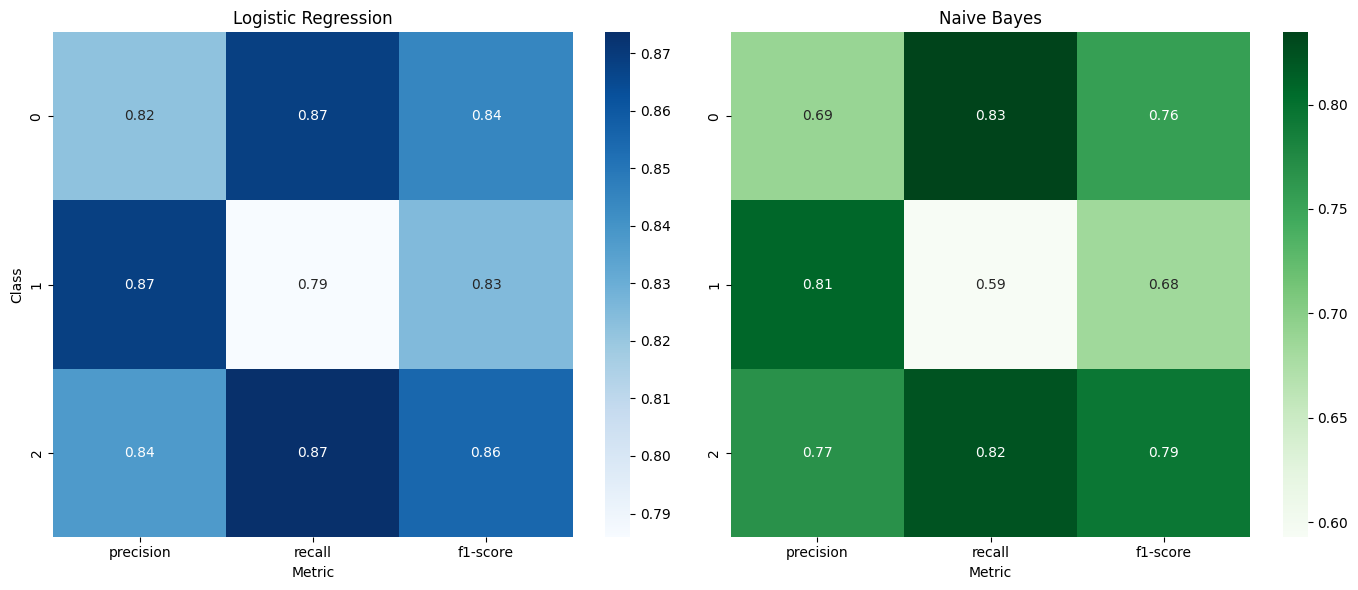

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

# Function to convert classification report to DataFrame
def report_to_df(y_true, y_pred):
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()
    df = df.iloc[:-3, :] 
    return df

# Get DataFrames
log_df = report_to_df(y_val, y_pred_log)
nb_df = report_to_df(y_val, y_pred_nb)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(log_df[['precision','recall','f1-score']], annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
axes[0].set_title("Logistic Regression")
axes[0].set_ylabel("Class")
axes[0].set_xlabel("Metric")

sns.heatmap(nb_df[['precision','recall','f1-score']], annot=True, fmt=".2f", cmap="Greens", ax=axes[1])
axes[1].set_title("Naive Bayes")
axes[1].set_ylabel("")
axes[1].set_xlabel("Metric")

plt.tight_layout()
plt.show()
